In [2]:
import pandas as pd
import numpy as np
import math
from typing import List, Tuple, Dict, Optional

csv_path = 'C:\\Users\\Roman Bolzern\\Desktop\\D4\\samples_training_2012-01-01T000000_2018-01-01T000000.csv'
train = pd.read_csv(csv_path, sep=";", parse_dates=["start","end","peak"], index_col="id")

*flux_to_class* maps the peak_flux of a flare to one of the following descriptors:

*free* = 1e-9, *B* >= 1e-7, *C* >= 1e-6, *M* >= 1e-5, and *X* >= 1e-4

In [3]:
goes_classes = ['free','A','B','C','M','X']

def flux_to_class(f: float, only_main=False):
    'Maps flux values to GOES classes'
    f = math.log10(f)
    main_class = goes_classes[min(int(f+9), 5)]
    sub_class = str(f)[2:4] if main_class != 'free' and only_main != True else ''
    return main_class + sub_class

def class_to_flux(c: str):
    log = goes_classes.index(c[0] if c != 'free' else c)-9
    sub = float(c[1:])/10 if c != 'free' else 0
    return math.pow(10, log+sub)

### Class counts
Examine the imbalance of flare strengths.

The "unique ARs" describes from how many different active region numbers (noaa_num) the flares come from.

In [4]:
noaa_nums = np.unique(train["noaa_num"])
classes_samples = [flux_to_class(pf, only_main=True) for pf in train["peak_flux"]]
max_classes_ARs = [flux_to_class(max(train[train["noaa_num"] == noaa_num]["peak_flux"]), only_main=True) for noaa_num in noaa_nums]
classes, counts_samples = np.unique(classes_samples, return_counts=True)
classes, counts_ARs = np.unique(max_classes_ARs, return_counts=True)
pd.DataFrame(data={"samples":counts_samples, "unique ARs":counts_ARs}, index=classes)

,samples,unique ARs
B,2173,117
C,4783,413
M,574,97
X,30,14
free,3586,450


### Divergence HEK vs GOES peak flux
Difference of manual labels by experts (HEK) with the recorded flux on the sun (GOES) on a log scale

MSE: 0.02377278293312221
L1:  0.11190021771996904
Max: 0.2740495298652945


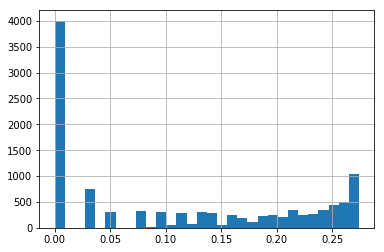

In [146]:
train['flux_from_hek'] = [class_to_flux(t) for t in train['type']]
logdiff = np.log10(train['flux_from_hek']) - np.log10(train['peak_flux'])
mse = (logdiff ** 2).mean()
l1 = abs(logdiff).mean()
print(f'MSE: {mse}')
print(f'L1:  {l1}')
print(f'Max: {max(abs(logdiff))}')
abs(logdiff).hist(bins=30)